In [1]:
from utils.util import *

## This is NOT the raw data. It is each file summarized down into a single row if using the '5sec' model, or 5 rows if using the '1sec' model

In [2]:
df_5sec = pd.read_csv(f'../data/complex_mafaulda_5sec.csv')
df_1sec = pd.read_csv(f'../data/complex_mafaulda_1sec.csv')
df_5sec.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path
0,11.700423,-0.028423,0.009096,0.209861,0.089478,0.081119,11.251919,0.144682,0.004352,0.020866,...,0.011994,0.028085,0.006391,0.022628,10.081655,1.920819,0.000409,60.6,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
1,11.691405,-0.315841,0.009299,0.171966,0.080338,0.063176,11.453312,0.634057,0.018882,0.015441,...,0.011745,0.025441,0.006911,0.024714,10.098573,2.051371,0.001856,59.2,vertical-misalignment,full/vertical-misalignment/1.78mm/60.6208.csv
2,11.691603,-0.314269,0.008901,0.167616,0.196603,0.045823,11.107915,0.434333,-0.011894,0.031162,...,0.011845,0.032116,0.021273,0.017417,10.207887,2.071535,-0.001486,58.6,vertical-misalignment,full/vertical-misalignment/1.78mm/60.0064.csv
3,11.715946,-0.040901,0.008365,0.172601,0.067104,0.116394,11.246643,0.829039,0.005535,0.022489,...,0.012393,0.027578,0.006499,0.020195,10.088735,2.064658,-0.001532,57.2,vertical-misalignment,full/vertical-misalignment/1.78mm/58.5728.csv
4,11.713568,-0.129168,0.008913,0.164138,0.064997,0.150388,11.184626,-0.092772,0.009297,0.017579,...,0.012543,0.025544,0.007792,0.023317,10.097232,2.038316,-0.000936,56.0,vertical-misalignment,full/vertical-misalignment/1.78mm/57.344.csv


In [3]:
# make our class dictionary
keys = list(np.unique(df_5sec['class']))
codes = [int(_) for _ in np.arange(0,len(keys))]
classDict = dict(zip(keys,codes))

df_5sec['CLASS'] = df_5sec['class']
df_5sec['class'] = df_5sec['class'].map(classDict)

df_1sec['CLASS'] = df_1sec['class']
df_1sec['class'] = df_1sec['class'].map(classDict)

classDict

{'horizontal-misalignment': 0,
 'imbalance': 1,
 'normal': 2,
 'overhang': 3,
 'underhang': 4,
 'vertical-misalignment': 5}

# First, do train/test split for 5sec data
# Then, use the same split for 1sec data
# This way, any file can be used to compare accuracy between the two models

In [4]:
drop = ['class','path','CLASS']
if 'startPoint' in df_5sec:
    drop.append('startPoint')
X5 = df_5sec.drop(columns=drop)
y5 = df_5sec['class']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, 
                                                    shuffle=True, random_state=45,
                                                    stratify=None)

print(f'Length of train set: {len(X5_train)}')
print(f'Length of test set: {len(X5_test)}')

Length of train set: 1560
Length of test set: 391


['./models/test_rfc_5sec.joblib']

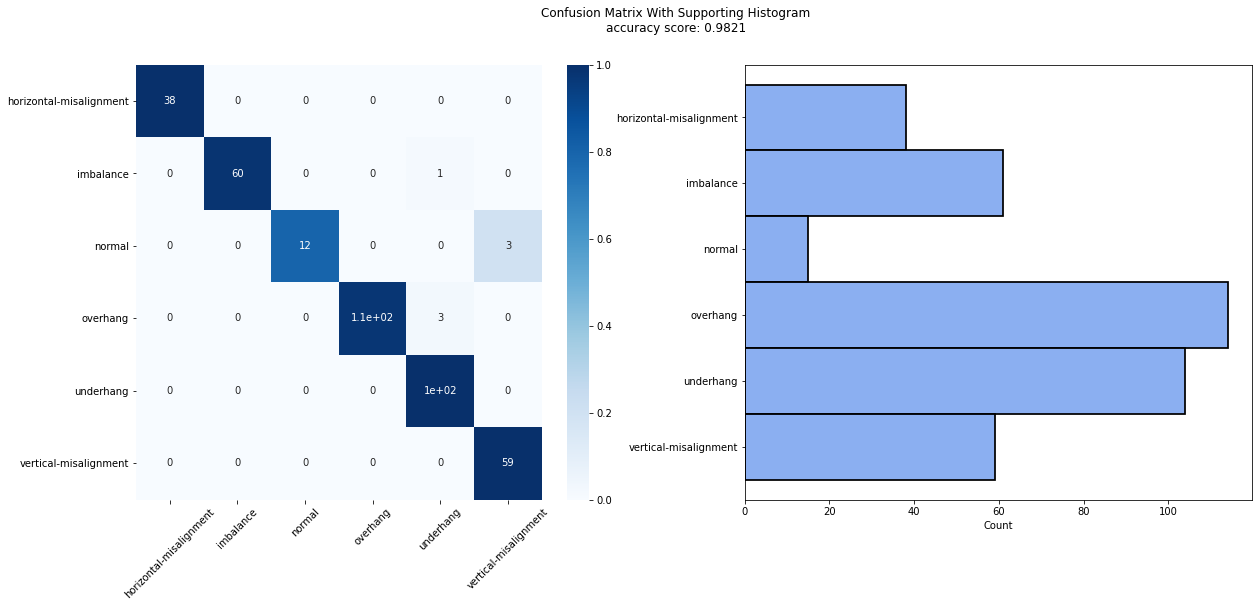

In [5]:
# used by the confusion_hist_plot function
target = 'class'

# define the model
model = RandomForestClassifier()

# train the model
model.fit(X5_train, y5_train)

# try to predict the data points we set aside for testing
preds5 = model.predict(X5_test)

#plot our results
confusion_hist_plot(df=df_5sec,y_test=y5_test,preds=preds5,codes=classDict);

# save the model
joblib.dump(model, f'./models/rfc_5sec.joblib')

In [6]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window
idxs = X5_test.index
idxs = [int(_) for _ in idxs]

val_files5 = df_5sec[['path','class','CLASS']].iloc[idxs]
val_files5.head()
val_files5.to_csv(f'./utils/test_files_5sec.csv')

# For every file in the 5sec dataset, there are 5 files in the 1sec dataset. This is how to find those indices in the 1sec dataset

In [7]:
index1 = []
for i in X5_train.index:
    I = i*5
    index1.extend([I,I+1,I+2,I+3,I+4])

In [8]:
train1 = df_1sec.loc[index1]
if 'startPoint' in df_1sec:
    drop.append('startPoint')
X1_train = train1.drop(columns=drop)
y1_train = train1['class']

test1 = df_1sec.drop(index=index1)
X1_test = test1.drop(columns=drop)
y1_test = test1['class']

['./models/test_rfc_1sec.joblib']

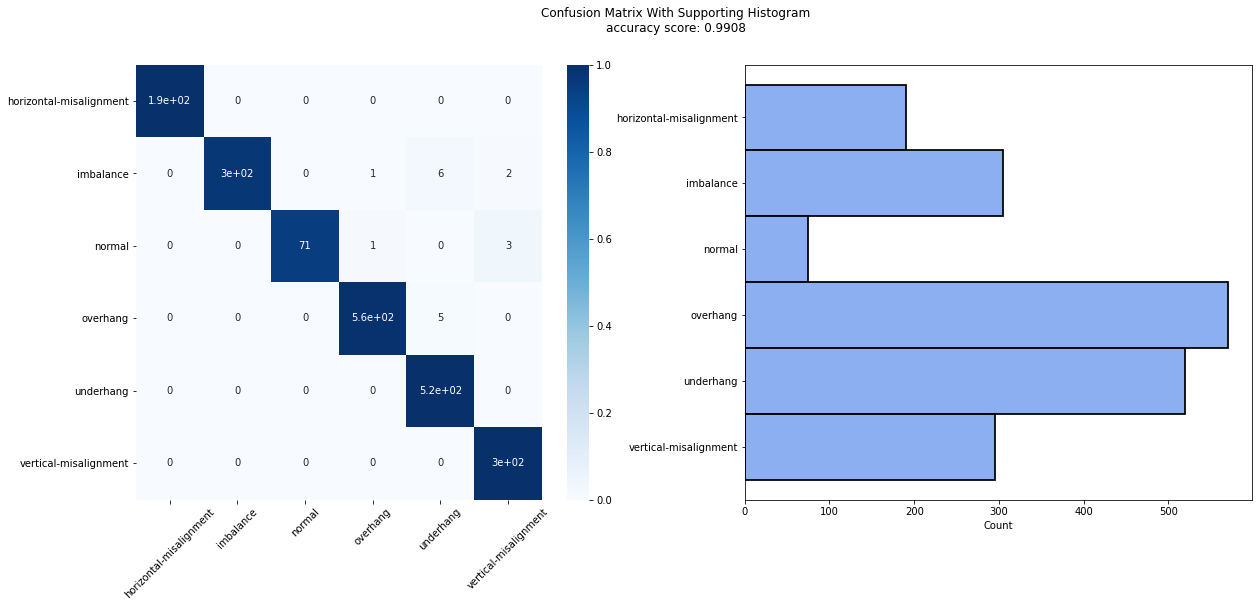

In [9]:
# used by the confusion_hist_plot function
target = 'class'

# define the model
model = RandomForestClassifier()

# train the model
model.fit(X1_train, y1_train)

# try to predict the data points we set aside for testing
preds1 = model.predict(X1_test)

#plot our results
confusion_hist_plot(df=df_1sec,y_test=y1_test,preds=preds1,codes=classDict);
joblib.dump(model, f'./models/rfc_1sec.joblib')

In [10]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window
idxs = X1_test.index
idxs = [int(_) for _ in idxs]

val_files1 = df_1sec[['path','class','CLASS']].iloc[idxs]
val_files1.head()
val_files1.to_csv(f'./utils/test_files_1sec.csv')

# Print out of some example files from each class. You will manually need to enter these file names into a config file for tests with specific file names

In [14]:
for key in classDict.keys():
    print(key)
    print(val_files5['path'][val_files5['CLASS'] == key].head())
    print('---------------------------')

horizontal-misalignment
1221    full/horizontal-misalignment/0.5mm/32.3584.csv
1270    full/horizontal-misalignment/1.5mm/33.9968.csv
1370    full/horizontal-misalignment/1.0mm/30.5152.csv
1204    full/horizontal-misalignment/0.5mm/49.5616.csv
1381    full/horizontal-misalignment/1.0mm/19.6608.csv
Name: path, dtype: object
---------------------------
imbalance
1163    full/imbalance/20g/41.5744.csv
1190     full/imbalance/20g/14.336.csv
953     full/imbalance/30g/12.0832.csv
1093    full/imbalance/10g/17.2032.csv
885     full/imbalance/15g/36.0448.csv
Name: path, dtype: object
---------------------------
normal
1420    full/normal/29.4912.csv
1402    full/normal/47.7184.csv
1396    full/normal/54.6816.csv
1399    full/normal/51.8144.csv
1398    full/normal/52.4288.csv
Name: path, dtype: object
---------------------------
overhang
1481       full/overhang/ball_fault/0g/61.44.csv
1579     full/overhang/outer_race/6g/57.5488.csv
1931    full/overhang/cage_fault/20g/32.1536.csv
1911     fu